In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 4.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73199 sha256=e6922a01ae812acc55df40eb16970a5af13f37d60f103a8f90086e9a34db4d16
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=615ba123f2f04611b1238f9e0d03ad8dae7dc8efebb6f624ce01ba20169d0a10
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/My Drive/kvasir-dataset.rar", outdir="/content/")

     |████████████████████████████████| 81kB 4.7MB/s 
patool: Extracting /content/drive/My Drive/kvasir-dataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/kvasir-dataset.rar"
patool:     with cwd='/content/'
patool: ... /content/drive/My Drive/kvasir-dataset.rar extracted to `/content/'.


'/content/'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
from keras.regularizers import l1,l2
from keras.models import Sequential
from keras.layers import Dropout , BatchNormalization , Flatten , MaxPooling2D , Activation , Dense , Conv2D , InputLayer , MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

Using TensorFlow backend.


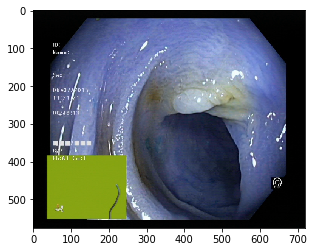

In [5]:
DATADIR_train = '/content/kvasir-dataset/kvasir-dataset-v2/train'
CATEGORIES= ['dyed-lifted-polyps' , 'dyed-resection-margins' , 'esophagitis' , 'normal-cecum' , 'normal-pylorus' , 'normal-z-line', 'polyps', 'ulcerative-colitis']
 
for category in CATEGORIES:
    path = os.path.join(DATADIR_train,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))#cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array , cmap='gray')
        break
    break    

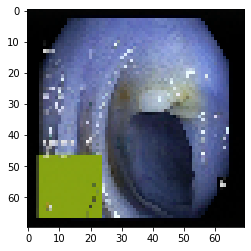

In [6]:
IMG_SIZE=70
new_array = cv2.resize(img_array , (IMG_SIZE,IMG_SIZE))
plt.imshow(new_array , cmap='gray')
plt.show()

In [0]:
training_data=[]

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR_train,category)
        class_num = CATEGORIES.index(category)  # giving number to each category or mapping each category to a no. 
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))#cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array , (IMG_SIZE,IMG_SIZE))
                training_data.append([new_array , class_num])
            except Exception as e:
                pass
        
        
create_training_data() 

In [0]:
X=[]
y=[]
for features,labels in training_data:
    X.append(features)
    y.append(labels)
     

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_train = np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,3)

X_train = X_train.astype("float32")/255 
X_test = X_test.astype("float32")/255

y_train = keras.utils.to_categorical(y_train , num_classes=8)
y_test = keras.utils.to_categorical(y_test , num_classes=8)

In [0]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [2,5]),
        activation='relu',
        input_shape=(70,70,3)
    ),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [2,5]),
        activation='relu'
    ),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [2,5]),
        activation='relu'
    ),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [2,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(8, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
tuner_search=RandomSearch(build_model,
                          objective='val_acc',
                          max_trials=5,directory='output',project_name="kvasir_kerastuner")

In [19]:
tuner_search.search(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Train on 6000 samples, validate on 2000 samples
Epoch 1/5
6000/6000 [==============================] - 2s 391us/sample - loss: 0.9642 - acc: 0.5775 - val_loss: 0.8701 - val_acc: 0.6195
Epoch 2/5
6000/6000 [==============================] - 2s 348us/sample - loss: 0.7041 - acc: 0.6765 - val_loss: 0.6825 - val_acc: 0.6890
Epoch 3/5
6000/6000 [==============================] - 2s 350us/sample - loss: 0.6397 - acc: 0.7122 - val_loss: 0.7493 - val_acc: 0.6660
Epoch 4/5
6000/6000 [==============================] - 2s 342us/sample - loss: 0.6120 - acc: 0.7320 - val_loss: 0.6157 - val_acc: 0.7145
Epoch 5/5
6000/6000 [==============================] - 2s 344us/sample - loss: 0.5737 - acc: 0.7382 - val_loss: 0.6385 - val_acc: 0.7140


Train on 6000 samples, validate on 2000 samples
Epoch 1/5
6000/6000 [==============================] - 3s 431us/sample - loss: 1.5417 - acc: 0.3628 - val_loss: 0.9068 - val_acc: 0.5670
Epoch 2/5
6000/6000 [==============================] - 2s 388us/sample - loss: 0.8679 - acc: 0.5812 - val_loss: 0.8090 - val_acc: 0.6045
Epoch 3/5
6000/6000 [==============================] - 2s 383us/sample - loss: 0.7953 - acc: 0.6230 - val_loss: 0.8250 - val_acc: 0.6050
Epoch 4/5
6000/6000 [==============================] - 2s 388us/sample - loss: 0.7867 - acc: 0.6238 - val_loss: 0.7809 - val_acc: 0.6020
Epoch 5/5
6000/6000 [==============================] - 2s 385us/sample - loss: 0.7437 - acc: 0.6415 - val_loss: 0.7729 - val_acc: 0.6190


Train on 6000 samples, validate on 2000 samples
Epoch 1/5
6000/6000 [==============================] - 2s 386us/sample - loss: 1.0625 - acc: 0.5298 - val_loss: 0.8197 - val_acc: 0.6030
Epoch 2/5
6000/6000 [==============================] - 2s 342us/sample - loss: 0.7345 - acc: 0.6645 - val_loss: 0.6647 - val_acc: 0.6985
Epoch 3/5
6000/6000 [==============================] - 2s 345us/sample - loss: 0.6768 - acc: 0.6908 - val_loss: 0.7573 - val_acc: 0.6520
Epoch 4/5
6000/6000 [==============================] - 2s 354us/sample - loss: 0.6172 - acc: 0.7097 - val_loss: 0.6242 - val_acc: 0.7095
Epoch 5/5
6000/6000 [==============================] - 2s 342us/sample - loss: 0.5878 - acc: 0.7318 - val_loss: 0.6318 - val_acc: 0.7240


Train on 6000 samples, validate on 2000 samples
Epoch 1/5
6000/6000 [==============================] - 2s 330us/sample - loss: 1.0306 - acc: 0.5528 - val_loss: 0.7787 - val_acc: 0.6475
Epoch 2/5
6000/6000 [==============================] - 2s 279us/sample - loss: 0.7216 - acc: 0.6728 - val_loss: 0.6746 - val_acc: 0.7065
Epoch 3/5
6000/6000 [==============================] - 2s 278us/sample - loss: 0.6339 - acc: 0.7072 - val_loss: 0.6422 - val_acc: 0.7200
Epoch 4/5
6000/6000 [==============================] - 2s 278us/sample - loss: 0.6129 - acc: 0.7223 - val_loss: 0.6071 - val_acc: 0.7200
Epoch 5/5
6000/6000 [==============================] - 2s 276us/sample - loss: 0.5771 - acc: 0.7438 - val_loss: 0.6369 - val_acc: 0.7190


Train on 6000 samples, validate on 2000 samples
Epoch 1/5
6000/6000 [==============================] - 2s 305us/sample - loss: 1.0251 - acc: 0.5308 - val_loss: 0.8728 - val_acc: 0.5840
Epoch 2/5
6000/6000 [==============================] - 2s 255us/sample - loss: 0.7080 - acc: 0.6760 - val_loss: 0.7092 - val_acc: 0.6780
Epoch 3/5
6000/6000 [==============================] - 2s 259us/sample - loss: 0.6319 - acc: 0.7067 - val_loss: 0.6502 - val_acc: 0.7015
Epoch 4/5
6000/6000 [==============================] - 2s 251us/sample - loss: 0.6045 - acc: 0.7205 - val_loss: 0.6102 - val_acc: 0.7155
Epoch 5/5
6000/6000 [==============================] - 2s 254us/sample - loss: 0.5778 - acc: 0.7312 - val_loss: 0.5953 - val_acc: 0.7275


INFO:tensorflow:Oracle triggered exit


In [0]:
model=tuner_search.get_best_models(num_models=1)[0]

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 69, 69, 48)        624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        76864     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          1

In [22]:
kerastunermodel = model.fit(X_train, y_train, epochs=30, validation_data=(X_test,y_test))

Train on 6000 samples, validate on 2000 samples
Epoch 1/30
6000/6000 [==============================] - 2s 271us/sample - loss: 0.5558 - acc: 0.7397 - val_loss: 0.5836 - val_acc: 0.7305
Epoch 2/30
6000/6000 [==============================] - 2s 251us/sample - loss: 0.5362 - acc: 0.7598 - val_loss: 0.5572 - val_acc: 0.7570
Epoch 3/30
6000/6000 [==============================] - 1s 248us/sample - loss: 0.5272 - acc: 0.7635 - val_loss: 0.5765 - val_acc: 0.7445
Epoch 4/30
6000/6000 [==============================] - 2s 255us/sample - loss: 0.4933 - acc: 0.7745 - val_loss: 0.5595 - val_acc: 0.7580
Epoch 5/30
6000/6000 [==============================] - 2s 252us/sample - loss: 0.4725 - acc: 0.7883 - val_loss: 0.5451 - val_acc: 0.7600
Epoch 6/30
6000/6000 [==============================] - 2s 253us/sample - loss: 0.4486 - acc: 0.7998 - val_loss: 0.5314 - val_acc: 0.7600
Epoch 7/30
6000/6000 [==============================] - 2s 250us/sample - loss: 0.4331 - acc: 0.8118 - val_loss: 0.5810 - va